<a href="https://colab.research.google.com/github/JW-292/Final-Team6/blob/main/%EA%B0%80%EC%84%A41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================== Robust flow: 1 → 2 → 4 =====================
import re, numpy as np, pandas as pd
from IPython.display import display, HTML
from scipy.stats import binomtest, f_oneway, kruskal, ttest_ind, mannwhitneyu
import statsmodels.api as sm

CSV_PATH = "/content/숙박 예약 서비스 사용 경험 조사.csv"
df = pd.read_csv(CSV_PATH, encoding="utf-8")
print(f"로드: {df.shape}")

# ---------- A) 값 기반 컬럼 탐색 ----------
def detect_tier_col(df):
    # 값에 '슈퍼/마스터/루키/등급없' 같은 등급 단어가 많은 열을 찾는다
    pat = re.compile(r"슈퍼|마스터|루키|등급\s*없", re.I)
    best, best_col = 0, None
    for c in df.columns:
        s = df[c].astype(str)
        pct = s.str.contains(pat, na=False).mean()
        if pct > best:
            best, best_col = pct, c
    return best_col, best

def detect_wtp_col(df):
    # 값에 '만원' 또는 '$'나 '~', 'or more', 'Under'가 흔한 열을 찾는다
    pat = re.compile(r"만원|\$|~|or more|Under", re.I)
    best, best_col = 0, None
    for c in df.columns:
        s = df[c].astype(str)
        pct = s.str.contains(pat, na=False).mean()
        if pct > best:
            best, best_col = pct, c
    return best_col, best

tier_col, tier_hit = detect_tier_col(df)
wtp_col,  wtp_hit  = detect_wtp_col(df)

print("탐색된 등급 컬럼:", tier_col, "(hit rate:", round(tier_hit,3), ")")
print("탐색된 WTP  컬럼:", wtp_col,  "(hit rate:", round(wtp_hit,3),  ")")

# 필요하면 여기서 수동으로 고정
# tier_col = "..."   # '슈퍼/마스터/루키/등급없음'이 값에 들어있는 열
# wtp_col  = "..."   # '만원' 또는 '$'가 들어있는 가격구간 열

assert tier_col in df.columns, "등급 컬럼을 찾지 못했습니다. tier_col을 수동 지정하세요."
assert wtp_col  in df.columns, "WTP  컬럼을 찾지 못했습니다. wtp_col을 수동 지정하세요."

# ---------- B) 1단계: 등급 선택 분포 + 간단 검정 ----------
tiers = df[tier_col].astype(str)
# 상위 등급 플래그: '슈퍼' 또는 '마스터'가 들어가면 1
high_tier = tiers.str.contains(r"슈퍼|마스터", na=False).astype(int)
df["_high_tier"] = high_tier

tier_counts = tiers.value_counts(dropna=False)
display(HTML("<h4>1단계) 등급별 선택 분포</h4>"))
display(tier_counts.rename_axis("tier").reset_index(name="count"))

p_hat = high_tier.mean()
n_eff = high_tier.size
binom_res = binomtest(high_tier.sum(), n=n_eff, p=0.5, alternative="greater")

print("\n[1단계 요약]")
print(f"- 고등급 선택 비율: {p_hat:.3f} (n={n_eff})")
print(f"- 단측 이항검정 (p>0.5): p = {binom_res.pvalue:.4g}")

# ---------- C) 2단계: WTP 한/영 혼합 문구 파싱 ----------
KRW = 10_000

def parse_wtp_to_krw(s):
    if pd.isna(s): return np.nan
    s = str(s)
    # 한글/숫자 부분만 먼저 사용 (달러 표기 뒤는 버린다)
    s_krw = s.split("$")[0].strip()

    # 케이스1: "A만원 이상 B만원 미만" -> (A+B)/2 * 1만원
    m = re.findall(r'(\d+)\s*만원', s_krw)
    if '이상' in s_krw and '미만' in s_krw and len(m) >= 2:
        a, b = map(int, m[:2])
        return ((a + b) / 2) * KRW

    # 케이스2: "X만원 미만" -> [0, X) 중위값 = X/2 * 1만원
    if '미만' in s_krw and len(m) >= 1:
        a = int(m[0])
        return (a / 2) * KRW

    # 케이스3: "Y만원 이상" -> 하한만 있을 때 관례로 +0.5만원
    if '이상' in s_krw and len(m) >= 1:
        a = int(m[0])
        return (a + 0.5) * KRW

    # 케이스4: 순수 범주 텍스트(영문만)인 경우는 NaN 처리
    return np.nan

df["_wtp"] = df[wtp_col].apply(parse_wtp_to_krw)

# 등급별 평균 WTP
wtp_by_tier = df.groupby(tier_col)["_wtp"].mean().sort_values(ascending=False)
display(HTML("<h4>2단계) 등급별 평균 WTP (KRW)</h4>"))
display(wtp_by_tier.rename_axis("tier").reset_index(name="mean_wtp"))

# ANOVA & Kruskal (집단 수 ≥2, 각 집단 표본 ≥2)
groups = [g["_wtp"].dropna().values for _, g in df.groupby(tier_col) if g["_wtp"].notna().sum() >= 2]
if len(groups) >= 2 and all(len(g) >= 2 for g in groups):
    fstat, p_anova = f_oneway(*groups)
    hstat, p_kruskal = kruskal(*groups)
else:
    fstat = p_anova = hstat = p_kruskal = np.nan

print("\n[2단계 요약]")
print(f"- ANOVA p-value: {p_anova if pd.notna(p_anova) else 'NA'}")
print(f"- Kruskal p-value: {p_kruskal if pd.notna(p_kruskal) else 'NA'}")

# ---------- D) 4단계: 간단 영향력(고등급 vs 비고등급 WTP) ----------
wtp_hi = df.loc[df["_high_tier"]==1, "_wtp"].dropna().values
wtp_lo = df.loc[df["_high_tier"]==0, "_wtp"].dropna().values

print("\n[4단계-WTP 효과 요약]")
if len(wtp_hi) >= 2 and len(wtp_lo) >= 2:
    # 평균 차이(등분산 가정X): Welch t
    t_stat, p_t = ttest_ind(wtp_hi, wtp_lo, equal_var=False, nan_policy='omit')
    # 분포 차이: Mann-Whitney
    u_stat, p_mw = mannwhitneyu(wtp_hi, wtp_lo, alternative='two-sided')
    # Cohen's d
    na, nb = len(wtp_hi), len(wtp_lo)
    va, vb = np.var(wtp_hi, ddof=1), np.var(wtp_lo, ddof=1)
    sp = np.sqrt(((na-1)*va + (nb-1)*vb) / (na+nb-2)) if (na>1 and nb>1) else np.nan
    d = (np.mean(wtp_hi) - np.mean(wtp_lo)) / sp if sp>0 else np.nan

    print(f"- 평균(고등급) = {np.mean(wtp_hi):.0f}원, 평균(비고등급) = {np.mean(wtp_lo):.0f}원")
    print(f"- Welch t-test p = {p_t:.4g}")
    print(f"- Mann–Whitney p = {p_mw:.4g}")
    print(f"- Cohen's d = {d:.3f}")
else:
    print("비교 가능한 표본이 부족합니다 (각 그룹 ≥2 필요).")

# (참고) 로지스틱은 all-0/all-1이면 완전분리로 실패 → 이 경우 위 이항검정 결과로 충분



로드: (133, 10)
탐색된 등급 컬럼: 6. 숙소를 예약한다면 다음 중 어떤 호스트의 숙소를 예약할 것인지 알려주세요.
(높은 등급일수록 더 나은 서비스와 시설이 제공 되며, 이에 따른 가격 차이가 발생할 수 있습니다. )

If you were to book an accommodation, which type of host’s listing would you choose?
(Higher tiers may provide better service and facilities, and price differences may occur accordingly.) (hit rate: 0.789 )
탐색된 WTP  컬럼: 8. 더 높은 등급에게 예약을 원할 경우, 추가로 지불할 의향이 있는 최대 금액을 알려주세요.
*등급에 따라 서비스 수준이 높아지는 부분에서 가격 차이가 생길 수 있습니다. 이때 감당 가능하다고 생각하시는 최대 금액을 알려주세요. 

If you prefer to book a higher-tier host, please indicate the maximum additional amount you are willing to pay. 
*Since the level of service may increase depending on the tier, price differences can occur. Please specify the maximum amount you consider acceptable. (hit rate: 1.0 )


,tier,count
0,1. 마스터 호스트 Master Host,54
1,2. 슈퍼 호스트 Super Host,32
2,3. 라이징 호스트 Rising Host,28
3,5. 등급 없음 No rating,17
4,4. 루키 호스트 Rookie Host,1
5,1. 마스터 호스트,1



[1단계 요약]
- 고등급 선택 비율: 0.654 (n=133)
- 단측 이항검정 (p>0.5): p = 0.0002386


,tier,mean_wtp
0,1. 마스터 호스트,35000.000000
1,3. 라이징 호스트 Rising Host,25357.142857
2,1. 마스터 호스트 Master Host,25000.000000
3,2. 슈퍼 호스트 Super Host,23750.000000
4,5. 등급 없음 No rating,21470.588235
5,4. 루키 호스트 Rookie Host,15000.000000



[2단계 요약]
- ANOVA p-value: 0.8362013528223464
- Kruskal p-value: 0.4375113398856135

[4단계-WTP 효과 요약]
- 평균(고등급) = 24655원, 평균(비고등급) = 23696원
- Welch t-test p = 0.7371
- Mann–Whitney p = 0.5624
- Cohen's d = 0.063


로드: (133, 10)
tier_col = 6. 숙소를 예약한다면 다음 중 어떤 호스트의 숙소를 예약할 것인지 알려주세요.
(높은 등급일수록 더 나은 서비스와 시설이 제공 되며, 이에 따른 가격 차이가 발생할 수 있습니다. )

If you were to book an accommodation, which type of host’s listing would you choose?
(Higher tiers may provide better service and facilities, and price differences may occur accordingly.)
reason_col = 7. 직전 문항 선택시 우선으로 고려한 사항을 선택해주세요.
Please select the factor you prioritized when answering the previous question.


,"6. 숙소를 예약한다면 다음 중 어떤 호스트의 숙소를 예약할 것인지 알려주세요.\n(높은 등급일수록 더 나은 서비스와 시설이 제공 되며, 이에 따른 가격 차이가 발생할 수 있습니다. )\n\nIf you were to book an accommodation, which type of host’s listing would you choose?\n(Higher tiers may provide better service and facilities, and price differences may occur accordingly.)",7. 직전 문항 선택시 우선으로 고려한 사항을 선택해주세요.\nPlease select the factor you prioritized when answering the previous question.
0,1. 마스터 호스트,3. 응답률
1,4. 루키 호스트 Rookie Host,2. 평균 평점 Average rating
2,1. 마스터 호스트 Master Host,5. 리뷰 수 Number of reviews
3,1. 마스터 호스트 Master Host,3. 응답률 Response rate
4,2. 슈퍼 호스트 Super Host,5. 리뷰 수 Number of reviews
5,1. 마스터 호스트 Master Host,5. 리뷰 수 Number of reviews
6,1. 마스터 호스트 Master Host,2. 평균 평점 Average rating
7,1. 마스터 호스트 Master Host,2. 평균 평점 Average rating
8,2. 슈퍼 호스트 Super Host,1. 예약 건수 Number of bookings
9,5. 등급 없음 No rating,5. 리뷰 수 Number of reviews



[Q7 원문 top 10]
_reason_raw
평균 평점 Average rating        58
리뷰 수 Number of reviews      42
예약 건수 Number of bookings    17
응답률 Response rate           10
예약 취소율 Cancellation rate     5
응답률                          1

[매핑 결과 분포]
_reason5
avg_rating       58
num_reviews      42
num_bookings     17
response_rate    11
cancel_rate       5


_reason5,avg_rating,cancel_rate,num_bookings,num_reviews,response_rate
_high_tier,,,,,
0,19,3,2,18,4
1,39,2,15,24,7


_reason5,avg_rating,cancel_rate,num_bookings,num_reviews,response_rate
_high_tier,,,,,
0,0.413043,0.065217,0.043478,0.391304,0.086957
1,0.448276,0.022989,0.172414,0.275862,0.080460


,chi2,p_value,df,cramers_V,high_tier_rate
0,6.711781,0.151926,4,0.224643,0.654135


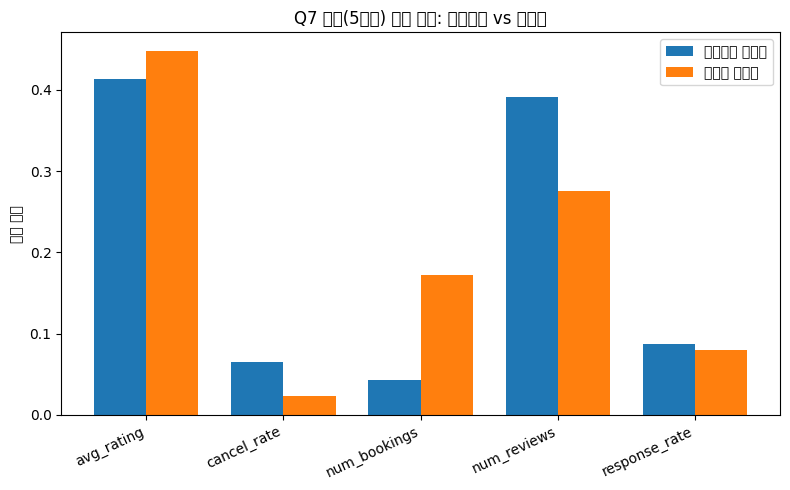

In [ ]:
# =================== Q6×Q7 정확 매핑 교정 버전 ===================
import re, os
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 0) 데이터 로드
CSV_PATH = "/content/숙박 예약 서비스 사용 경험 조사.csv"
df = pd.read_csv(CSV_PATH, encoding="utf-8")
print(f"로드: {df.shape}")

# 1) 컬럼을 '명시적으로' 고정 (이게 포인트!)
tier_col   = df.columns[7]  # "6. 숙소를 예약한다면..."
reason_col = df.columns[8]  # "7. 직전 문항 선택시 우선으로 고려한 사항..."

print("tier_col =", tier_col)
print("reason_col =", reason_col)
display(HTML("<h4>미리보기</h4>"))
display(df[[tier_col, reason_col]].head(10))

# 2) 전처리: Q6 고등급 플래그, Q7 문구 정리
df["_high_tier"] = df[tier_col].astype(str).str.contains(r"(마스터|슈퍼|Master|Super)", na=False).astype(int)

def clean_reason_text(s: str) -> str:
    if pd.isna(s): return ""
    t = str(s).strip()
    # 줄바꿈/긴 설명 제거 → 한 줄로
    t = re.sub(r"\s+", " ", t)
    # 항목 앞번호 "1. " 같은 접두 제거
    t = re.sub(r"^\s*\d+\.\s*", "", t)
    return t

df["_reason_raw"] = df[reason_col].apply(clean_reason_text)

# 3) Q7을 5개 카테고리로 매핑 (한/영 이중언어 대응)
#    실제 옵션이 아래 다섯 개여야 합니다:
#    - 평균 평점(Average rating) / 리뷰 수(Number of reviews) / 예약 건수(Number of bookings)
#    - 응답률(Response rate) / 취소율(Cancellation rate)
def map_reason_5cats(s: str) -> str:
    t = s
    # 평균 평점
    if re.search(r"(평균\s*평점|Average rating|rating)", t, re.I):
        return "avg_rating"
    # 리뷰 수
    if re.search(r"(리뷰\s*수|후기\s*수|Number of reviews|reviews?)", t, re.I):
        return "num_reviews"
    # 예약 건수
    if re.search(r"(예약\s*건수|Number of bookings|bookings?)", t, re.I):
        return "num_bookings"
    # 응답률
    if re.search(r"(응답률|Response rate|response)", t, re.I):
        return "response_rate"
    # 취소율
    if re.search(r"(취소율|Cancellation rate|cancel(l)?ation|cancel)", t, re.I):
        return "cancel_rate"
    return "other"

df["_reason5"] = df["_reason_raw"].apply(map_reason_5cats)

# 디버그: Q7 값 top과 매핑 결과 분포 확인
print("\n[Q7 원문 top 10]")
print(df["_reason_raw"].value_counts().head(10).to_string())
print("\n[매핑 결과 분포]")
print(df["_reason5"].value_counts().to_string())

# 4) 교차표 & 카이제곱 & Cramér's V
ct_counts = pd.crosstab(df["_high_tier"], df["_reason5"])
ct_ratio  = pd.crosstab(df["_high_tier"], df["_reason5"], normalize="index")

chi2, pval, dof, exp = chi2_contingency(ct_counts)
N = ct_counts.to_numpy().sum()
V = np.sqrt(chi2 / (N * (min(ct_counts.shape) - 1))) if N>0 and min(ct_counts.shape)>1 else np.nan

display(HTML("<h4>교차표(빈도)</h4>")); display(ct_counts)
display(HTML("<h4>교차표(비율)</h4>")); display(ct_ratio)
summary = pd.DataFrame([{
    "chi2": chi2, "p_value": pval, "df": dof, "cramers_V": V,
    "high_tier_rate": df["_high_tier"].mean()
}])
display(HTML("<h4>카이제곱 검정 요약</h4>")); display(summary)

# 5) 시각화 (한글 폰트 경고는 무시해도 됨)
plot_df = ct_ratio.T.reset_index()
plot_df.columns = ["reason", "prob_low_tier", "prob_high_tier"]

plt.figure(figsize=(8,5))
x = np.arange(len(plot_df["reason"]))
w = 0.38
plt.bar(x - w/2, plot_df["prob_low_tier"], width=w, label="비고등급 선택자")
plt.bar(x + w/2, plot_df["prob_high_tier"], width=w, label="고등급 선택자")
plt.xticks(x, plot_df["reason"], rotation=25, ha="right")
plt.ylabel("선택 비율")
plt.title("Q7 이유(5분류) 선택 비율: 비고등급 vs 고등급")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# =========================================================
# Colab one-shot (robust): 배지(등급) → 선택/지불의향 간접 검증
# - 희소 범주 병합 -> singular 방지
# - Logit 실패 시 규제 로지스틱으로 폴백
# - OLS(HC3)로 WTP 차이 검정
# =========================================================
import re, numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ---------------- 0) Load ----------------

CSV_PATH = "/content/숙박 예약 서비스 사용 경험 조사.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
print(f"✅ 로드: {df.shape}")

# ---------------- 1) 컬럼 지정 ----------------
col_nat, col_age, col_plat, col_factor = df.columns[1], df.columns[2], df.columns[3], df.columns[4]
col_tier, col_reason, col_wtp = df.columns[7], df.columns[8], df.columns[9]

# ---------------- 2) 파생 ----------------
# 고등급 선택
df["_high_tier"] = df[col_tier].astype(str).str.contains(r"(마스터|슈퍼|Master|Super)", na=False).astype(int)

# WTP 범주 → 수치(중위값, KRW)
KRW = 10_000
rules = [
    (r"1만원\s*미만|Under\s*\$10", 0.5*KRW),
    (r"1만원\s*이상\s*2만원\s*미만|\$10\s*~\s*\$20", 1.5*KRW),
    (r"2만원\s*이상\s*3만원\s*미만|\$20\s*~\s*\$30", 2.5*KRW),
    (r"3만원\s*이상\s*4만원\s*미만|\$30\s*~\s*\$40", 3.5*KRW),
    (r"4만원\s*이상\s*5만원\s*미만|\$40\s*~\s*\$50", 4.5*KRW),
    (r"5만원\s*이상|\$50\s*or\s*more", 5.5*KRW),
]
def map_wtp(s):
    t = str(s)
    for pat, val in rules:
        if re.search(pat, t, flags=re.I):
            return val
    return np.nan
df["_wtp"] = df[col_wtp].apply(map_wtp)

# ---------------- 3) 희소 레벨 병합 ----------------
def collapse_rare(s: pd.Series, min_count=3, other_label="Other"):
    vc = s.value_counts(dropna=False)
    rare = vc[vc < min_count].index
    return s.where(~s.isin(rare), other_label)

df["_nat_c"]    = collapse_rare(df[col_nat].astype(str))
df["_age_c"]    = collapse_rare(df[col_age].astype(str))
df["_plat_c"]   = collapse_rare(df[col_plat].astype(str))
df["_factor_c"] = collapse_rare(df[col_factor].astype(str))

# ---------------- 4) 안전한 컬럼명 ----------------
def to_safe_name(c):
    name = re.sub(r'[^0-9A-Za-z_]+', '_', str(c))
    if not re.match(r'^[A-Za-z_]', name):
        name = "V_" + name
    return name

df_safe = df.copy()
df_safe.columns = [to_safe_name(c) for c in df_safe.columns]

nat_c, age_c, plat_c, factor_c = map(to_safe_name, ["_nat_c","_age_c","_plat_c","_factor_c"])

print("\n[레벨 개수]")
for lab, col in [("국적",nat_c), ("연령",age_c), ("플랫폼",plat_c), ("중요요인",factor_c)]:
    print(f"- {lab}: {df_safe[col].nunique()} levels")

# ---------------- 5) 로지스틱 (일반 → 실패 시 규제) ----------------
formula_logit = f"_high_tier ~ C({nat_c}) + C({age_c}) + C({plat_c}) + C({factor_c})"

try:
    logit = smf.logit(formula_logit, data=df_safe).fit(disp=False)
    used_regularized = False
except Exception as e:
    print("\n⚠️ 일반 Logit 실패:", repr(e))
    # patsy로 디자인 행렬을 직접 만들어 규제 적합
    import patsy
    y, X = patsy.dmatrices(formula_logit, df_safe, return_type='dataframe')
    # 규제 로지스틱 (L1+L2 혼합 가능, 여기선 L2 성격의 alpha 사용)
    logit = sm.Logit(y, X).fit_regularized(alpha=1.0, maxiter=2000)
    used_regularized = True

print("\n========== [로지스틱] _high_tier ~ 국적+연령+플랫폼+중요요인 ==========")
if hasattr(logit, "summary"):
    print(logit.summary())
else:
    # fit_regularized는 summary가 간략함
    print("계수(규제):")
    print(pd.Series(logit.params, index=X.columns))

# OR & p-values (규제일 땐 p-value 제공X)
if hasattr(logit, "params"):
    params = logit.params
    OR = np.exp(params)
    print("\n[오즈비 OR(Exp(beta))]")
    print(OR.to_string())
if not used_regularized:
    or_table = np.exp(logit.params).rename("OR").to_frame()
    or_table["p-value"] = logit.pvalues
    print("\n[오즈비 OR & p-values]")
    print(or_table.to_string())
else:
    print("\n※ 규제 로지스틱은 p-value를 제공하지 않습니다(계수/방향만 참고).")

# ---------------- 6) OLS(HC3): WTP ~ _high_tier + 국적 + 연령 ----------------
ols_df = df_safe.dropna(subset=["_wtp"]).copy()
formula_ols = f"_wtp ~ _high_tier + C({nat_c}) + C({age_c})"
ols = smf.ols(formula_ols, data=ols_df).fit(cov_type="HC3")
print("\n================ [OLS(HC3)] _wtp ~ _high_tier + 국적 + 연령 ================")
print(ols.summary())
coef_ht = float(ols.params.get("_high_tier", np.nan))
p_ht    = float(ols.pvalues.get("_high_tier", np.nan))
print(f"\n⇒ 해석: 고등급 선택자의 WTP 증분 = {coef_ht:,.0f}원 (p={p_ht:0.3f})")

# ---------------- 7) 요약 ----------------
print("\n====================== [요약] ======================")
print(f"- 표본 수: N={len(df)} (WTP 유효표본: {len(ols_df)})")
print(f"- 고등급 선택 비율: {df['_high_tier'].mean():.3f}")
print(f"- 로지스틱: {'규제(fit_regularized) 사용' if used_regularized else '일반 최대우도'}")
print("  · 계수/OR 방향만 참고 (규제 시 p-value 없음)")
print(f"- OLS 결과: _high_tier 계수 {coef_ht:,.0f}원, p={p_ht:0.3f}  → 0.05 기준 {'유의' if p_ht<0.05 else '비유의'}")
print("※ 이 분석은 실제 로그가 아닌 설문 기반의 '실적 유사 지표' 검증입니다.")





✅ 로드: (133, 10)

[레벨 개수]
- 국적: 3 levels
- 연령: 5 levels
- 플랫폼: 6 levels
- 중요요인: 6 levels

⚠️ 일반 Logit 실패: LinAlgError('Singular matrix')
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6319108322826381
            Iterations: 61
            Function evaluations: 62
            Gradient evaluations: 61

========== [로지스틱] _high_tier ~ 국적+연령+플랫폼+중요요인 ==========
                           Logit Regression Results                           
Dep. Variable:             _high_tier   No. Observations:                  133
Model:                          Logit   Df Residuals:                      124
Method:                           MLE   Df Model:                            8
Date:                Mon, 22 Sep 2025   Pseudo R-squ.:                 0.05919
Time:                        16:46:26   Log-Likelihood:                -80.689
converged:                       True   LL-Null:                       -85.765
Covariance Type:            nonrobust   LLR